# 1. Import Required Libraries

In [18]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# 2. Load data

In [19]:
def load_smoking_data(data_dir, img_size=224):
    X, y = [], []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        img_name_lower = img_name.lower()

        if "notsmoking" in img_name_lower:
            label = 0
        elif "smoking" in img_name_lower:
            label = 1
        else:
            continue

        X.append(img)
        y.append(label)
    
    X = np.array(X).astype(np.float32)
    X = preprocess_input(X)  
    return X, np.array(y)

In [20]:
X, y = load_smoking_data("/kaggle/input/smoker-1k2/Training", img_size=224)
print("Count image:", X.shape[0])
print("Shape image:", X.shape[1:])

Count image: 1120
Shape image: (224, 224, 3)


# 3. Visualize Images

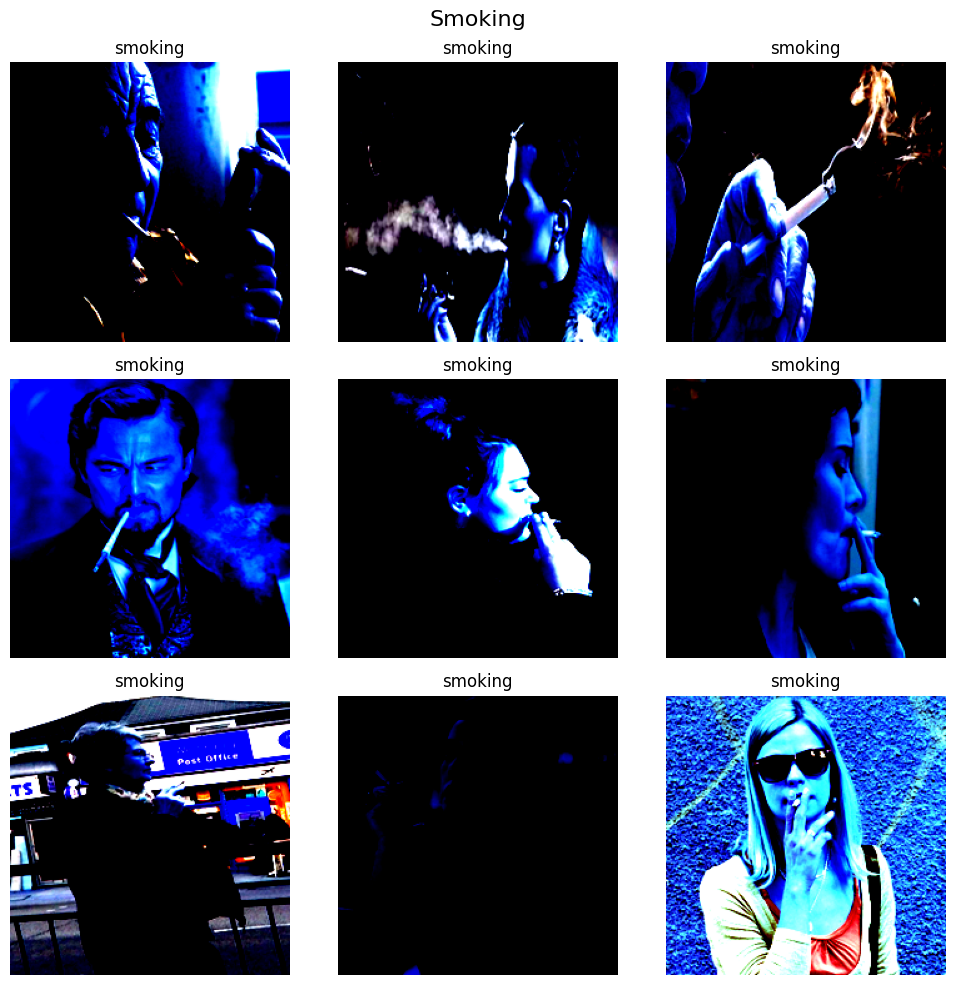

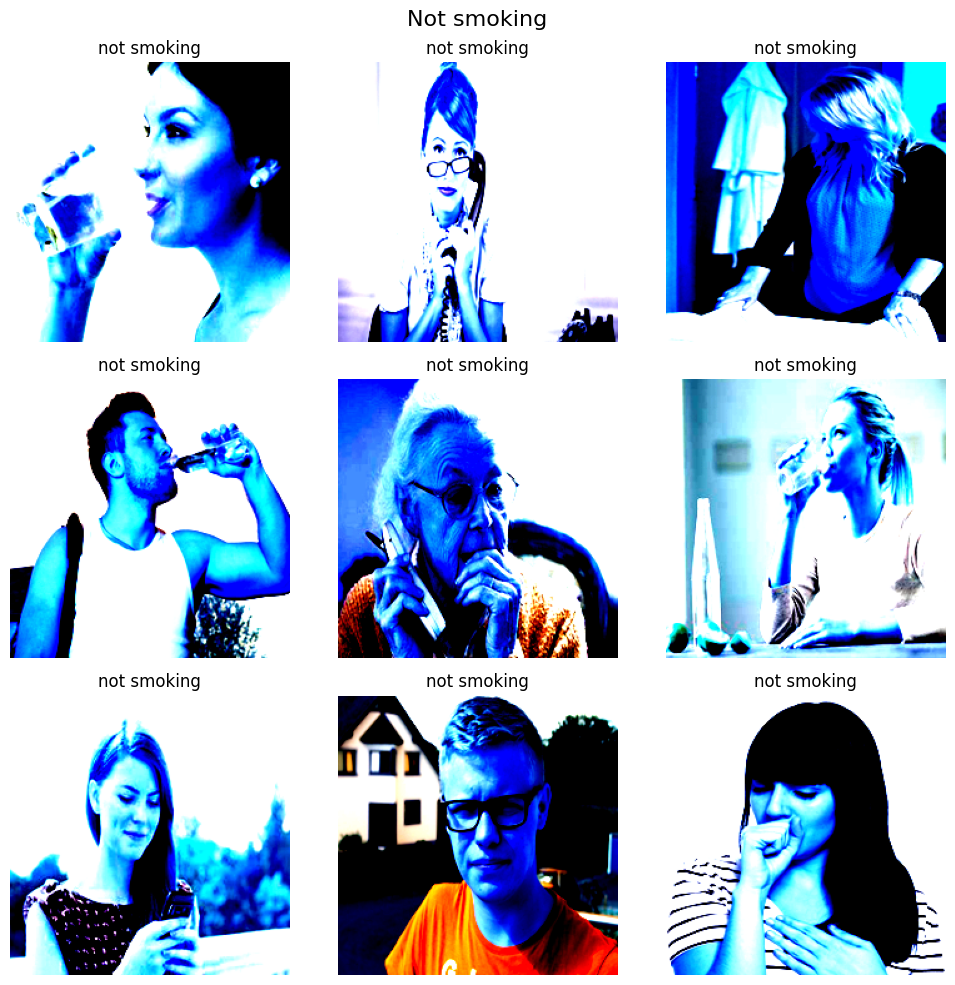

In [21]:
class_names = ['not smoking', 'smoking']

def plot_sample(X, y, label, title):
    indices = [i for i in range(len(y)) if y[i] == label]
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[idx])
        plt.title(class_names[y[idx]])
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample(X, y, 1, "Smoking")
plot_sample(X, y, 0, "Not smoking")

# 4. Split data

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [23]:
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (784, 224, 224, 3)
Validation set shape: (168, 224, 224, 3)
Test set shape: (168, 224, 224, 3)


In [24]:
print("Train Labels:", y_train.shape)
print("Validation Labels:", y_val.shape)
print("Test Labels:", y_test.shape)

Train Labels: (784,)
Validation Labels: (168,)
Test Labels: (168,)


# 5. Load Model

In [25]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 6. Train - Data Augmentation

In [26]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.25,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2)
)
datagen.fit(X_train)

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5562 - loss: 0.9151 - val_accuracy: 0.8274 - val_loss: 0.5159
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.6764 - loss: 0.6025 - val_accuracy: 0.7798 - val_loss: 0.4907
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.7247 - loss: 0.5520 - val_accuracy: 0.8571 - val_loss: 0.4078
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.7693 - loss: 0.4787 - val_accuracy: 0.8631 - val_loss: 0.3637
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.7856 - loss: 0.4643 - val_accuracy: 0.8571 - val_loss: 0.3749
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.8008 - loss: 0.4445 - val_accuracy: 0.8512 - val_loss: 0.3640
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.8302 - loss: 0.3993 - val_accuracy: 0.8452 - val_loss: 0.3700


# 7. Fine turn model

In [28]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

fine_history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7722 - loss: 0.5067 - val_accuracy: 0.8750 - val_loss: 0.3135
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.8623 - loss: 0.3046 - val_accuracy: 0.8869 - val_loss: 0.2947
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.8863 - loss: 0.2322 - val_accuracy: 0.8988 - val_loss: 0.3673
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.9299 - loss: 0.2108 - val_accuracy: 0.9048 - val_loss: 0.3346
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.9058 - loss: 0.1955 - val_accuracy: 0.8810 - val_loss: 0.4284


## Save model

In [29]:
model.save('densenet_smoking_detector.h5')

# 8. Evaluate on Test Data

In [30]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {acc:.4f}")
print(f"Loss: {loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9222 - loss: 0.2112
Accuracy: 0.9226
Loss: 0.2083


# 9. Predict Test Images with Actual vs Predicted

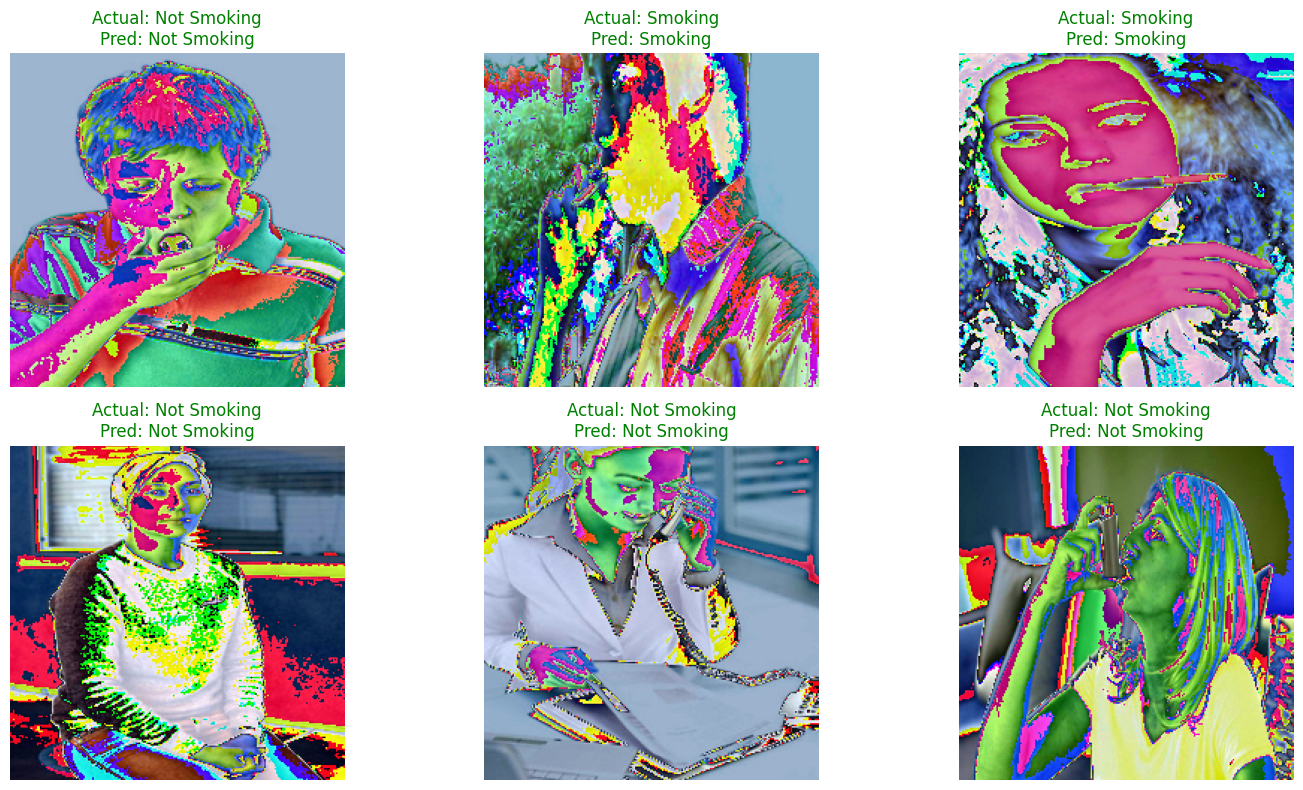

In [31]:
IMAGE_SIZE = (224, 224)

random_indices = random.sample(range(len(X_test)), 6)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    label = y_test[idx]

    # Dự đoán
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
    pred_label = "Smoking" if pred > 0.5 else "Not Smoking"
    true_label = "Smoking" if label == 1 else "Not Smoking"

    plt.subplot(2, 3, i + 1)
    plt.imshow(((img + 1) * 127.5).astype(np.uint8))  # chuyển ảnh về dạng hiển thị (do đã preprocess bằng DenseNet)
    plt.title(f"Actual: {true_label}\nPred: {pred_label}",
              color='green' if pred_label == true_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()